<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Classify objects by color tutorial

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
#%tensorflow_version 2.x
!pip install tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the Files tab
1. Drag `csv` files from your computer to the tab to upload them into colab.

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.



2025-12-05 20:26:57.547639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 20:26:57.560575: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-05 20:26:57.654185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-05 20:26:57.730380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764934017.805307  159316 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764934017.82

TensorFlow version = 2.19.1

apple class will be output 0 of the classifier
71 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



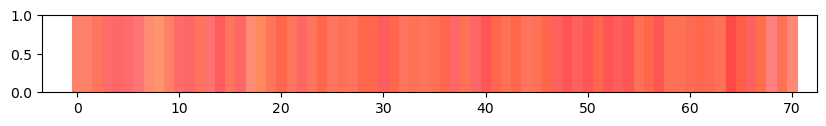

banana class will be output 1 of the classifier
94 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



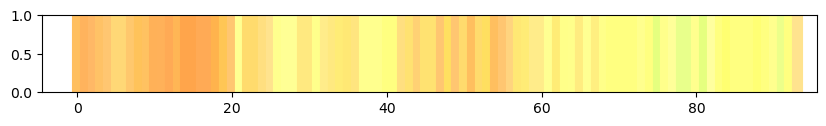

orange class will be output 2 of the classifier
91 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



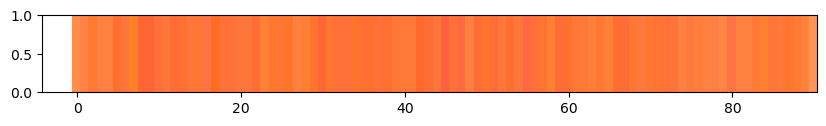

Data set parsing and preparation complete.
Data set randomization and splitting complete.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("./SampleData/"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()

SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("./SampleData/" + objectClass + ".csv")
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
   
  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")

  # graphing
  plt.rcParams["figure.figsize"] = (10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [3]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=400, batch_size=4, validation_data=(inputs_validate, outputs_validate))



Epoch 1/400


2025-12-05 20:27:46.237453: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2242 - mae: 0.4460 - val_loss: 0.2216 - val_mae: 0.4437
Epoch 2/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2204 - mae: 0.4426 - val_loss: 0.2185 - val_mae: 0.4407
Epoch 3/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2183 - mae: 0.4405 - val_loss: 0.2161 - val_mae: 0.4383
Epoch 4/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2166 - mae: 0.4387 - val_loss: 0.2140 - val_mae: 0.4361
Epoch 5/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2150 - mae: 0.4370 - val_loss: 0.2121 - val_mae: 0.4341
Epoch 6/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2134 - mae: 0.4353 - val_loss: 0.2100 - val_mae: 0.4318
Epoch 7/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2117 - mae: 0.4334 - val_loss: 0.2078 - val_mae: 0.4295
Epoch 8/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2099 - mae: 0.4315 - val_loss: 0.2055 - val_mae: 0.4269
Epoch 9/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2080 - mae: 0.4

### Run with Test Data
Put our test data into the model and plot the predictions


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
predictions =
 [[0.033 0.002 0.964]
 [0.028 0.972 0.   ]
 [0.125 0.003 0.872]
 [0.033 0.967 0.   ]
 [0.033 0.967 0.   ]
 [0.014 0.    0.986]
 [0.221 0.77  0.009]
 [0.024 0.001 0.975]
 [0.016 0.    0.984]
 [0.027 0.002 0.971]
 [0.037 0.963 0.   ]
 [0.986 0.013 0.001]
 [0.719 0.    0.281]
 [0.028 0.972 0.   ]
 [0.948 0.032 0.021]
 [0.054 0.946 0.   ]
 [0.036 0.006 0.959]
 [0.02  0.001 0.979]
 [0.038 0.962 0.   ]
 [0.125 0.003 0.872]
 [0.417 0.021 0.562]
 [0.133 0.867 0.   ]
 [0.992 0.006 0.002]
 [0.886 0.114 0.001]
 [0.014 0.    0.986]
 [0.028 0.972 0.   ]
 [0.948 0.032 0.021]
 [0.033 0.002 0.964]
 [0.02  0.001 0.979]
 [0.984 0.002 0.014]
 [0.038 0.962 0.   ]
 [0.027 0.002 0.971]
 [0.393 0.059 0.548]
 [0.024 0.001 0.975]
 [0.027 0.973 0.   ]
 [0.126 0.021 0.853]
 [0.992 0.006 0.002]
 [0.033 0.967 0.   ]
 [0.024 0.001 0.975]
 [0.221 0.77  0.009]
 [0.029 0.971 0.   ]
 [0.052 0.948 0.   ]
 [0.02  0.001 0.979]
 [0.027 0.002 0.971]
 [0.017 0.    0.982]
 [

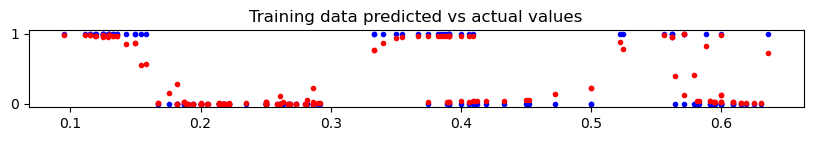

In [4]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [5]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpk9kc3i72/assets


INFO:tensorflow:Assets written to: /tmp/tmpk9kc3i72/assets


Saved artifact at '/tmp/tmpk9kc3i72'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138154213654160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138154213654352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138154213653584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138154176154704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138154176154320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138154176155280: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1764934266.283389  159316 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764934266.283427  159316 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-05 20:31:06.283841: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpk9kc3i72
2025-12-05 20:31:06.284211: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-05 20:31:06.284218: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpk9kc3i72
I0000 00:00:1764934266.286226  159316 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-12-05 20:31:06.286637: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-05 20:31:06.305485: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpk9kc3i72
2025-12-05 20:31:06.309923: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

Model is 2484 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [6]:
!echo "const unsigned char model[] = {" > ./content/model.h
!cat gesture_model.tflite | xxd -i      >> ./content/model.h
!echo "};"                              >> ./content/model.h

import os
model_h_size = os.path.getsize("./content/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 15,352 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Realtime Classification of Sensor Data on Arduino

Now it's time to switch back to the tutorial instructions and run our new model on the [Arduino Nano 33 BLE Sense](https://www.arduino.cc/en/Guide/NANO33BLE)